# OSMAND GPS tracks to GeoPackage

The purpose of this script is to aggregate a set of GPX files (traces only, not POI) from the OsmAnd app. It allows to clean up the periods without displacement, to filter the too high or too low speeds, to determine a minimum displacement distance between two points and to remove the too abrupt angles.


In this example, 115 GPX files collected during movements in Chad were used.

# Import libs

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import os
import pyproj
import math
from xml.dom import minidom
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

# Functions

In [2]:
def calculate_bearing(pointA, pointB):
    """
    from : https://gist.github.com/jeromer/2005586
    
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing, initial_bearing

# Parameters

In this section, the filtering and the input/output file parameters are defined.

In [18]:
# Location of gpx files. The sub-folders are also taken into account
path = r"D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp"

# Location for exported file
export_location = r"D:\Users\gisspecialist2\Documents\GIS\data\Gpx"
exported_filename = r"\agpx_4_cell_adre.gpkg"

# Iso3 of the country
iso_3 = 'TCD'

# Max and min speed allowed (km/h).Speeds outside this range will not be taken into consideration.
max_speed = 120
min_speed = 8

# Min distance between two gps point (km)
min_dist = 0.03  #!! The recording interval between GPS points must be taken into considaration (1sec, 5 sec, 15sec, ...)

# Max turn allowed (in degree) between consecutive points. Over this angle, the point is dropped
illegal_turn = 60

# Import GPX from a specific folder and subdirectories

In [4]:
gpx_files = []
extension = ".gpx"

# Get List of all files in directory and Sub-directories
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(extension):
            # Append the file name to the list
            gpx_files.append(os.path.join(root,file))

print("Files found :",len(gpx_files))

Files found : 115


# GPX to GDF

## Extract GPX data and load into a master gdf
This block of code will iterate over each GPX file to parse it and extract latitutde, longitude, timestamp, speed at the point and altitude. For each point, the distance and the speed between the point and the next one will be calculated, also the bearing.

The results will then be added to a gdf with a track number and a number for each point in its track.

In [5]:
# Create df to store the gps points
df = pd.DataFrame(columns=['trk_nb',
                           'trk_order',
                           'lon',
                           'lat',
                           'elev',
                           'pt_speed', # Speed at time T of the recording point.
                           'datetime',
                           'time',
                           'time_next',
                           'time_delta',
                           'dist_next',
                           'speed',  # Actual speed between points, in km/h.
                           'bearing',
                           'bearing_delta',
                           'initial_bearing',
                           'file_name',
                           'geometry'])

# Create master gdf to hold all data
m_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=3857)

print(f"Processing {len(gpx_files)} GPX files:") 

# Iterate over each .gpx
for i, gpx_file in enumerate(gpx_files):

    print(f'Processing {i} :', gpx_file)

    # Get element from GPX
    data = open(gpx_file)
    xmldoc = minidom.parse(data)
    track = xmldoc.getElementsByTagName('trkpt')
    elevation = xmldoc.getElementsByTagName('ele')
    datetime = xmldoc.getElementsByTagName('time')
    pt_speed = xmldoc.getElementsByTagName('osmand:speed')

    # Iterate over each gpx waypoint to parse and transform data
    for s in range(len(track)):

        # Lat lon
        lat, lon = track[s].attributes['lat'].value, track[s].attributes['lon'].value

        # Altitude
        try:
            elev = elevation[s].firstChild.nodeValue
        # Needed because sometime the elevation is missing in the .gpx
        except:
            speed = np.nan

        # Datetime
        try:
            timestamp = datetime[s].firstChild.nodeValue
        # Needed because sometime the date is missing in the .gpx
        except:
            timestamp = np.nan

        # Speed at delta T
        try:
            speed = pt_speed[s].firstChild.nodeValue
        # Needed because sometime the speed is missing in the .gpx
        except:
            speed = np.nan
            
        # Get filename
        name = gpx_file.split("\\")[-1]
        name = name.replace(".gpx", "")

        # Append to df
        df = df.append({'lon': float(lon),
                        'lat': float(lat),
                        'elev': elev,
                        'datetime': timestamp,
                        'pt_speed': speed,
                        'trk_nb': i,
                        'trk_order': s,
                        'file_name': name
                        },
                       ignore_index=True)

    # Calcul bearing
    for i, r in df.iloc[1:].iterrows():
        b = df.lat[i], df.lon[i]
        a = df.lat[i-1], df.lon[i-1]

        df.loc[i, 'bearing'],df.loc[i, 'initial_bearing'] = calculate_bearing(tuple(a),
                                                                                  tuple(b)
                                                                                  )
        # Get bearing delta
        df.loc[i-1, 'bearing_delta'] = abs(round((abs(df.loc[i-1, 'initial_bearing']) - abs(df.loc[i, 'initial_bearing'])),0))

    # Convert to datetime
    df['datetime'] = pd.to_datetime(
        df['datetime'], dayfirst=True, utc=True)

    # Drop row with no datetime
    temp_len = len(df)
    df = df[df['datetime'].notnull()]
    temp_len1 = len(df)

    # Check if rows were dropped
    if temp_len - temp_len1 != 0:
        print("Row without datetime dropped : ", temp_len - temp_len1)

    # Get time delta
    df['time'] = df['datetime'].dt.time
    df['time_next'] = df['time'].shift(-1)
    df['time_delta'] = df['datetime'].diff().dt.total_seconds().shift(-1)

    # Convert df to a gdf and add geometry
    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df.lon, df.lat),
                           crs=4326
                           )
    
    # Transfrom to metric Mercator WGS84
    gdf.to_crs(3857, inplace=True)

    # Shift the dataframe by 1 to align pnt1 with pnt2 (next one)
    points_df2 = gdf['geometry'].shift(-1)
    gdf['dist_next'] = gdf['geometry'].distance(points_df2)

    # Get kilometer / hour to next point
    gdf['speed'] = round(
        (gdf['dist_next']/1000) / (df['time_delta']/3600), 0)

    # Concat to m_gdf
    m_gdf = pd.concat([m_gdf, gdf], axis=0)

# Print gdf info
print(m_gdf.crs.axis_info[0].unit_name)
print(m_gdf.crs)
m_gdf

Processing 115 GPX files:
Processing 0 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j3\2\2022-07-13_06-34_Wed.gpx
Processing 1 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j3\2\2022-07-13_10-23_Wed.gpx
Processing 2 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j3\3\2022-07-13_06Ar.gpx
Processing 3 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j3\4\2022-07-13_06-24_Wed.gpx
Processing 4 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j4\1a\2022-07-13_07-34_Wed.gpx
Processing 5 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j4\1a\2022-07-14_06-28_Thu.gpx
Processing 6 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j4\1a\Farchana-Adré.gpx
Processing 7 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j4\2\adre -hh-attichane _adre.gpx
Processing 8 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\j4\3\2022-07-14_06-32_Thu.gpx
Processing 9 : D:\Users\g

Processing 71 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-20_adre_tongori.gpx
Processing 72 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-20_adre_tongori_biske.gpx
Processing 73 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-20_hilouta_biske.gpx
Processing 74 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-20_tongori_biske.gpx
Processing 75 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-21_adre_abougoulem_traone.gpx
Processing 76 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-21_adre_farchana_abougoulem.gpx
Processing 77 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\GPX\adré_temp\Segmented_original\2022-04-21_adre_farchana_molou_birtaouil_baroud_rimete_tourane.gpx
Processing 78 : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\

,trk_nb,trk_order,lon,lat,elev,pt_speed,datetime,time,time_next,time_delta,dist_next,speed,bearing,bearing_delta,initial_bearing,file_name,geometry
0,0,0,22.204646,13.466068,799.3,0,2022-07-13 05:34:10+00:00,05:34:10,05:34:26,16.0,0.036099,0.0,NaN,NaN,NaN,2022-07-13_06-34_Wed,POINT (2471809.864 1513030.142)
1,0,1,22.204646,13.466068,799.3,0,2022-07-13 05:34:26+00:00,05:34:26,05:34:41,15.0,12.814066,3.0,197.961104,10.0,-162.038896,2022-07-13_06-34_Wed,POINT (2471809.853 1513030.107)
2,0,2,22.204630,13.465957,793.4,1.1,2022-07-13 05:34:41+00:00,05:34:41,05:34:57,16.0,2.830407,1.0,187.839031,50.0,-172.160969,2022-07-13_06-34_Wed,POINT (2471808.105 1513017.413)
3,0,3,22.204652,13.465944,794.2,0,2022-07-13 05:34:57+00:00,05:34:57,05:35:13,16.0,1.625041,0.0,122.26459,86.0,122.26459,2022-07-13_06-34_Wed,POINT (2471810.498 1513015.902)
4,0,4,22.204643,13.465955,794.2,0,2022-07-13 05:35:13+00:00,05:35:13,05:35:29,16.0,0.015967,0.0,323.418027,99.0,-36.581973,2022-07-13_06-34_Wed,POINT (2471809.530 1513017.207)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104835,114,863,21.614258,13.099461,587.60,NaN,2022-04-26 15:23:18+00:00,15:23:18,15:23:33,15.0,92.014369,22.0,177.394753,2.0,177.394753,2022-06-26_adre_allacha_alt1,POINT (2406088.194 1471097.741)
104836,114,864,21.614247,13.098656,574.50,NaN,2022-04-26 15:23:33+00:00,15:23:33,15:23:49,16.0,106.798211,24.0,180.762508,32.0,-179.237492,2022-06-26_adre_allacha_alt1,POINT (2406086.970 1471005.735)
104837,114,865,21.613733,13.097867,608.20,NaN,2022-04-26 15:23:49+00:00,15:23:49,15:24:05,16.0,101.645105,23.0,212.395531,19.0,-147.604469,2022-06-26_adre_allacha_alt1,POINT (2406029.752 1470915.557)
104838,114,866,21.613022,13.097309,605.30,NaN,2022-04-26 15:24:05+00:00,15:24:05,15:24:21,16.0,36.959873,8.0,231.139191,29.0,-128.860809,2022-06-26_adre_allacha_alt1,POINT (2405950.604 1470851.782)


## Clean GDF from unusable data
After printing some statistics on speed and distance between points, the rows are filtered based on the parameters defined in the "Parameters" section.

In [6]:
# Check for unrealistic values
print("Speed")
print(m_gdf['speed'].describe())

print("\nDist_next")
print(m_gdf['dist_next'].describe())

speed
count    8.552745e+06
mean     1.912373e+01
std      1.971857e+01
min     -1.050000e+03
25%      0.000000e+00
50%      1.700000e+01
75%      3.500000e+01
max      5.350000e+02
Name: speed, dtype: float64

dist_next
count    8.552745e+06
mean     9.126091e+01
std      1.453925e+03
min      0.000000e+00
25%      1.146191e-02
50%      3.489103e+01
75%      1.090784e+02
max      1.105547e+05
Name: dist_next, dtype: float64


In [7]:
a = len(m_gdf)
print('gdf lenght: ',a)

# Drop row with illegal turn
clean_gdf = m_gdf[m_gdf['bearing_delta'] <= illegal_turn ]
b = len(clean_gdf)
print('rows dropped "Illegal turn": ',a-b)

# Correct highspeed
clean_gdf['speed'].loc[clean_gdf['speed'] >= max_speed] = np.nan
c = len(clean_gdf)
print('rows dropped "Correct highspeed": ',b-c)

# Drop too low speed (in km/h) and Null
clean_gdf = clean_gdf[clean_gdf['speed'] >= min_speed ]
clean_gdf = clean_gdf[clean_gdf['speed'].notnull()]

d = len(clean_gdf)
print('rows dropped "Too low speed and Null": ',c-d)

# Drop too small distance (km) between points
clean_gdf = clean_gdf[clean_gdf['dist_next'] >= min_dist ]
e = len(clean_gdf)
print('rows dropped "Too small distance" : ',d-e)

print('gdf lenght: ',e)

gdf lenght:  8552860
rows dropped "Illegal turn":  748060
rows dropped  "Correct highspeed":  0
rows dropped "Too low speed and Null":  3181524
rows dropped "Too small distance" :  0
gdf lenght:  4623276


In [8]:
# Print stats again
print("speed")
print(clean_gdf['speed'].describe())

print("\ndist_next")
print(clean_gdf['dist_next'].describe())

speed
count    4.623276e+06
mean     3.458426e+01
std      1.320125e+01
min      8.000000e+00
25%      2.500000e+01
50%      3.400000e+01
75%      4.300000e+01
max      1.190000e+02
Name: speed, dtype: float64

dist_next
count    4.623276e+06
mean     1.136176e+02
std      2.601140e+02
min      9.413691e+00
25%      5.586597e+01
50%      9.834986e+01
75%      1.612281e+02
max      7.815266e+04
Name: dist_next, dtype: float64


# Plot data on a map

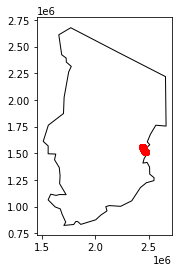

In [9]:
# Get world boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Transform to metric Mercator WGS84
world.to_crs(3857, inplace=True)

# Select an area by ISO3
ax = world[world.iso_a3 == iso_3].plot(
    color='white', edgecolor='black')

# We can now plot 
clean_gdf[0:1000].plot(ax=ax, color='red')
plt.show()

# Export to Geopackage

In [ ]:
# Need to change unsupported datetime column datatype for shapefile or gdb
clean_gdf[['datetime','time','time_next','time_delta']] = clean_gdf[['datetime','time','time_next','time_delta']].astype(str)

# Select only useful data
gdf_export = ['trk_nb',
               'trk_order',
               'elev',
               'datetime',
               'pt_speed',
               'speed',
               'dist_next',
               'bearing',
               'bearing_delta',
               'geometry']

gdf_export = clean_gdf[gdf_export]

In [21]:
# Export to gpkg
gdf_export.to_file(export_location + exported_filename  , 
              driver='GPKG', 
              layer='waypoint_gpx')  

print("Exported to :",export_location + exported_filename )

Exported to : D:\Users\gisspecialist2\Documents\GIS\data\Gpx\agpx_4_cell_adre.gpkg
